Idea: préciser pourquoi prendre une certaine partie des données => dans la data exploration analysis mettre en avant les inégalités et cooks distance, beaucpup dépasse le rule of thumb 
Solution: prendre un nombre maximal de lancé par combinaison de participants/coin

ON essaye de prendre le meme nombre de lancés par coin/person

heatmap ? 



In [70]:
library(dplyr)
library(ggplot2)
library(cat)
library(pROC)
library(tidyr)
set.seed(123)

In [2]:
df <- read.csv("coin data/analyses/data-agg.csv",header=T)
n <- nrow(df)
dfHeads <- df[,-c(2,4)] # heads to heads
dfTails <- df[,-c(1,3)] # tails to heads
dfTails[,1] <- dfTails[,2]-dfTails[,1] # tails to tails
names(dfHeads) <- names(dfTails) <- c("y", "m", "person", "coin")
start <- rep(c("heads","tails"),c(n,n))
df <- rbind(dfHeads,dfTails)
df$person <- factor(df$person); df$coin <- factor(df$coin); df$start <- factor(start) # nolint

In [3]:
df_long <- read.csv("coin data/analyses/data-long.csv",header=T)
df_time_agg <- read.csv("coin data/analyses/df-time-agg.csv",header=T)
df_time <- read.csv("coin data/analyses/df-time.csv",header=T)

In [4]:
names(df_time_agg)

[1] "heads_heads"      "tails_heads"      "N_start_heads_up" "N_start_tails_up"
 [5] "same_side"        "N"                "person"           "coin"            
 [9] "agg"              "from"             "to"               "mean_toss"

In [5]:
# POur prendre les X premieres lignes dans le data set 
# # Sélection des 3 premières lignes pour chaque combinaison Fruit-Couleur
# selected_data <- data %>%
#   group_by(Fruit, Couleur) %>%
#   slice_head(n = 3) %>%
#   ungroup()

# # Résultat
# print(selected_data)

# Data Analysis

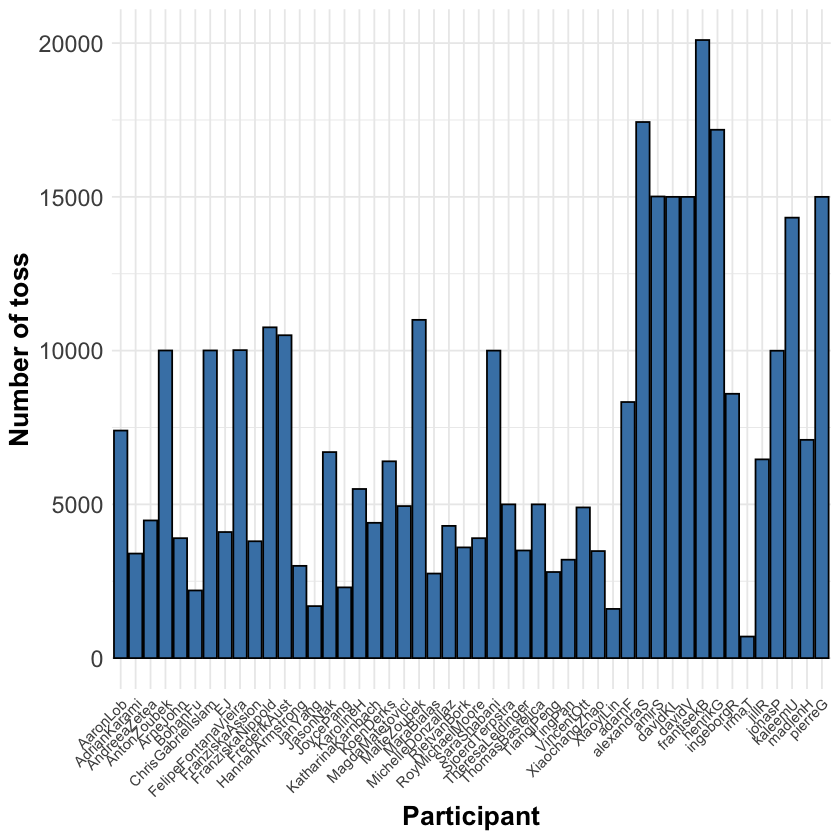

In [55]:
nb_toss_per_person <- df %>%
    select(m, person) %>%
    group_by(person) %>%
    summarise(m = sum(m))

ggplot(nb_toss_per_person, aes(x = person, y = m)) +
  geom_bar(stat = "identity", fill = "steelblue", color = "black") +
  labs(
       x = "Participant",
       y = "Number of toss") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),  # Taille des étiquettes x
    axis.text.y = element_text(size = 14),                        # Taille des étiquettes y
    axis.title.x = element_text(size = 16, face = "bold"),        # Taille et style du titre x
    axis.title.y = element_text(size = 16, face = "bold"),        # Taille et style du titre y
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5)
  )

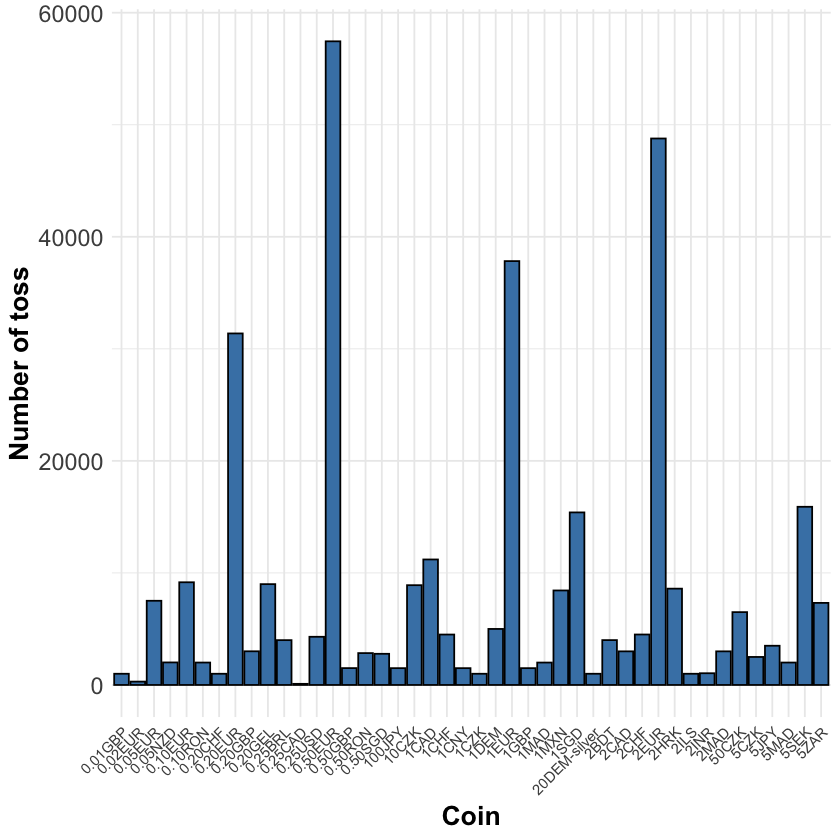

In [57]:
nb_toss_per_coin <- df %>%
    select(m, coin) %>%
    group_by(coin) %>%
    summarise(m = sum(m))

ggplot(nb_toss_per_coin, aes(x = coin, y = m)) +
  geom_bar(stat = "identity", fill = "steelblue", color = "black") +
  labs(
       x = "Coin",
       y = "Number of toss") +
  theme_minimal() +
 theme(
    axis.text.x = element_text(angle = 45, hjust = 1),  # Taille des étiquettes x
    axis.text.y = element_text(size = 14),                        # Taille des étiquettes y
    axis.title.x = element_text(size = 16, face = "bold"),        # Taille et style du titre x
    axis.title.y = element_text(size = 16, face = "bold"),        # Taille et style du titre y
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5)
  )

In [65]:
names(df)

[1] "y"               "m"               "person"          "coin"           
[5] "start"           "personNumber"    "coinNumber"      "predicted_probs"

As we can see, participants do not toss the same number of coins, so those who toss a lot will strongly influence the model’s results.

Similarly for the coins, those that appear less frequently have little influence on the model.

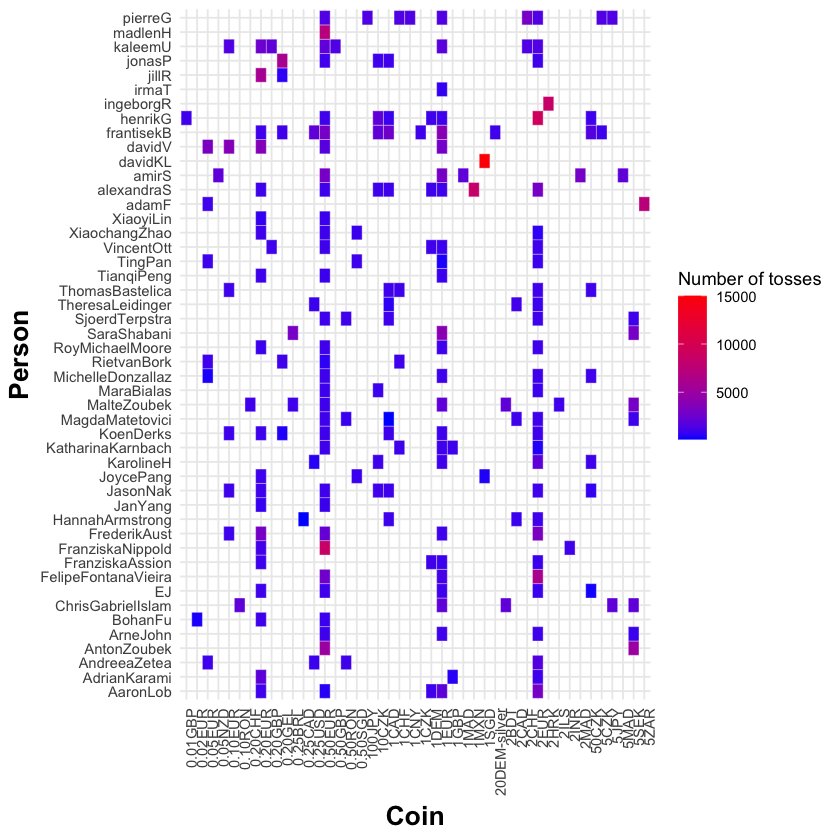

In [107]:
heatmap_data <- df %>%
  group_by(person, coin) %>%
  summarise(total_lancers = sum(m), .groups = "drop")

ggplot(heatmap_data, aes(x = coin, y = person, fill = total_lancers)) +
  geom_tile(color = "white") +
  scale_fill_gradient(low = "blue", high = "red", name = "Number of tosses") +
  labs(
       x = "Coin",
       y = "Person") +
   theme_minimal() +
   theme(
    axis.text.x = element_text( angle = 90, hjust = 1),  # Taille des étiquettes x
    axis.title.x = element_text(size = 16, face = "bold"),        # Taille et style du titre x
    axis.title.y = element_text(size = 16, face = "bold"),        # Taille et style du titre y
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5)
  )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  47.00   49.67   50.60   50.45   51.20   53.79 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  47.28   49.95   50.57   50.71   51.45   55.65 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  44.06   49.30   50.50   50.14   51.28   53.84 

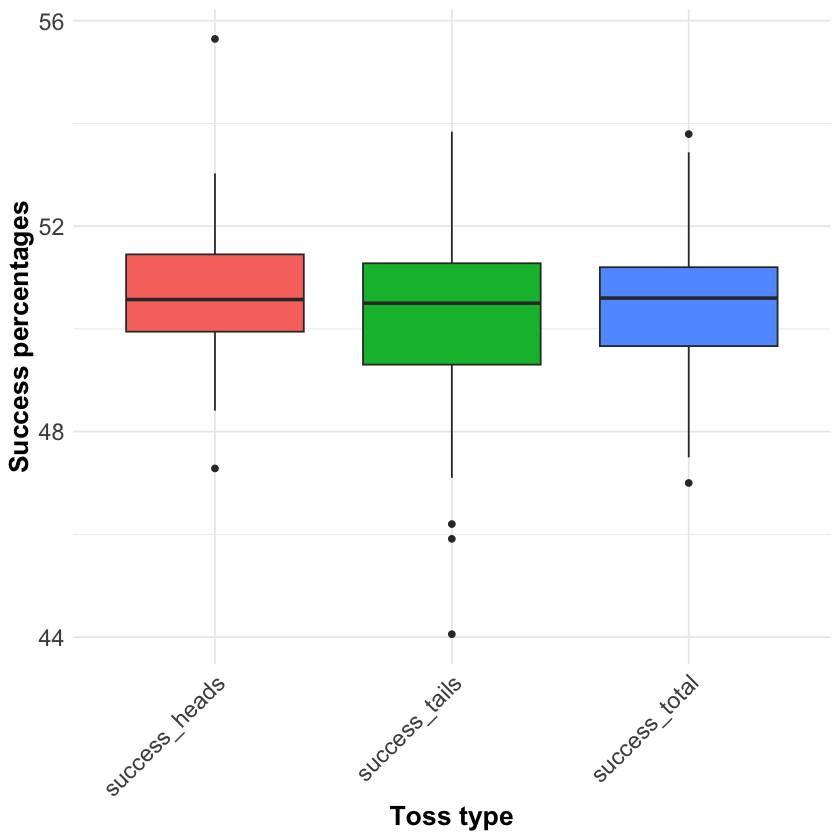

In [94]:
percentages <- df %>%
  group_by(coin) %>%
  summarise(
    success_total = 100 * sum(y) / sum(m),                                     # Pourcentage total
    success_heads = 100 * sum(y[start == "heads"]) / sum(m[start == "heads"]), # Pourcentage pour heads 
    success_tails = 100 * sum(y[start == "tails"]) / sum(m[start == "tails"])  # Pourcentage pour tails
  ) %>%
  pivot_longer(cols = starts_with("success"), names_to = "type", values_to = "percentage")


ggplot(percentages, aes(x = type, y = percentage, fill = type)) +
  geom_boxplot() +
  labs(
    #title = "Success percentages by toss type and coin",
    x = "Toss type",
    y = "Success percentages"
  ) +
  theme_minimal() +
   theme(
    axis.text.x = element_text(size = 14, angle = 45, hjust = 1),  # Taille des étiquettes x
    axis.text.y = element_text(size = 14),                        # Taille des étiquettes y
    axis.title.x = element_text(size = 16, face = "bold"),        # Taille et style du titre x
    axis.title.y = element_text(size = 16, face = "bold"),        # Taille et style du titre y
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5), 
    legend.position = "none"
  )

summary(percentages$percentage[percentages$type == "success_total"])
summary(percentages$percentage[percentages$type == "success_heads"])
summary(percentages$percentage[percentages$type == "success_tails"])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  48.75   50.04   50.52   51.05   51.71   60.07 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  47.53   49.99   50.75   51.02   51.80   58.17 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  47.86   49.75   50.63   51.05   51.75   61.82 

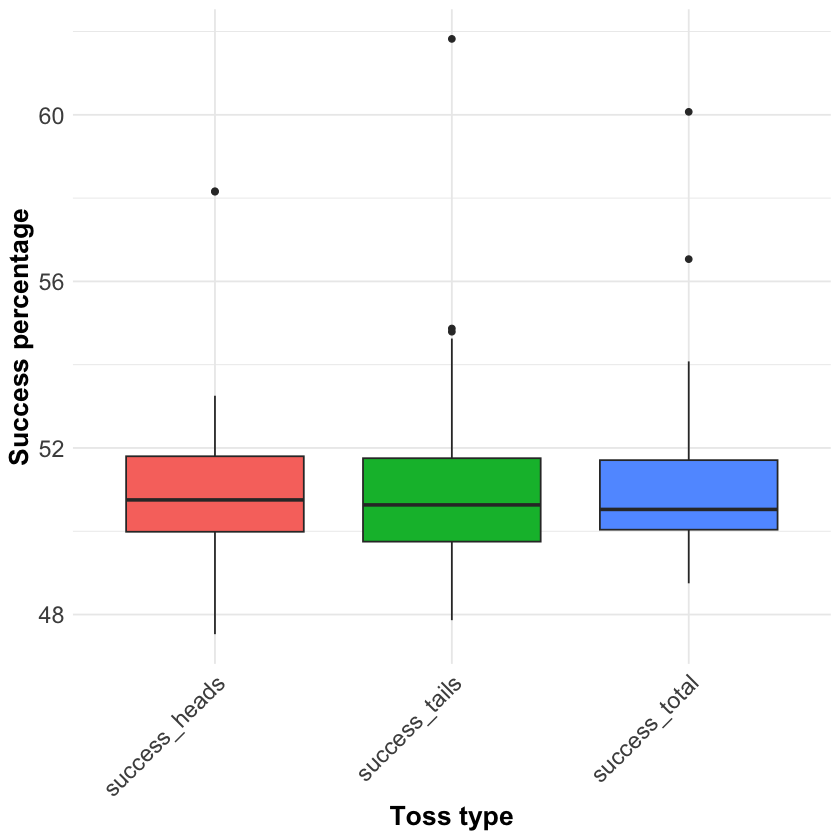

In [95]:
percentages <- df %>%
  group_by(person) %>%
  summarise(
    success_total = 100 * sum(y) / sum(m),                                     # Pourcentage total
    success_heads = 100 * sum(y[start == "heads"]) / sum(m[start == "heads"]), # Pourcentage pour heads 
    success_tails = 100 * sum(y[start == "tails"]) / sum(m[start == "tails"])  # Pourcentage pour tails
  ) %>%
  pivot_longer(cols = starts_with("success"), names_to = "type", values_to = "percentage")


ggplot(percentages, aes(x = type, y = percentage, fill = type)) +
  geom_boxplot() +
  labs(
    #title = "Success percentages by toss type and participant",
    x = "Toss type",
    y = "Success percentage"
  ) +
  theme_minimal() +
   theme(
    axis.text.x = element_text(size= 14, angle = 45, hjust = 1),  # Taille des étiquettes x
    axis.text.y = element_text(size = 14),                        # Taille des étiquettes y
    axis.title.x = element_text(size = 16, face = "bold"),        # Taille et style du titre x
    axis.title.y = element_text(size = 16, face = "bold"),        # Taille et style du titre y
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5), 
    legend.position = "none"
  )

summary(percentages$percentage[percentages$type == "success_total"])
summary(percentages$percentage[percentages$type == "success_heads"])
summary(percentages$percentage[percentages$type == "success_tails"])

`summarise()` has grouped output by 'person'. You can override using the
`.groups` argument.


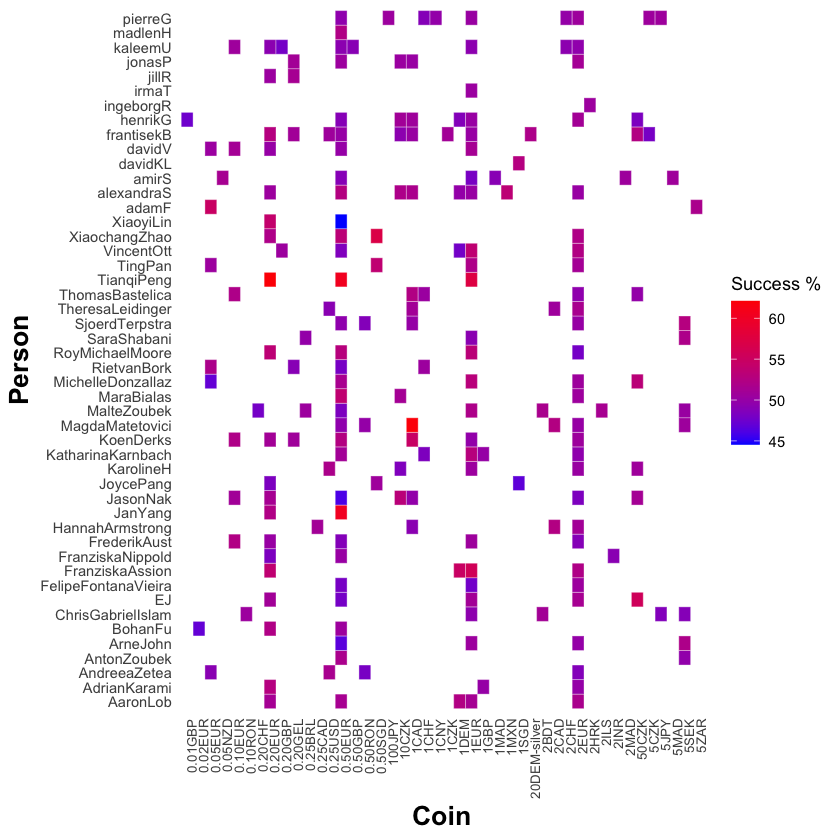

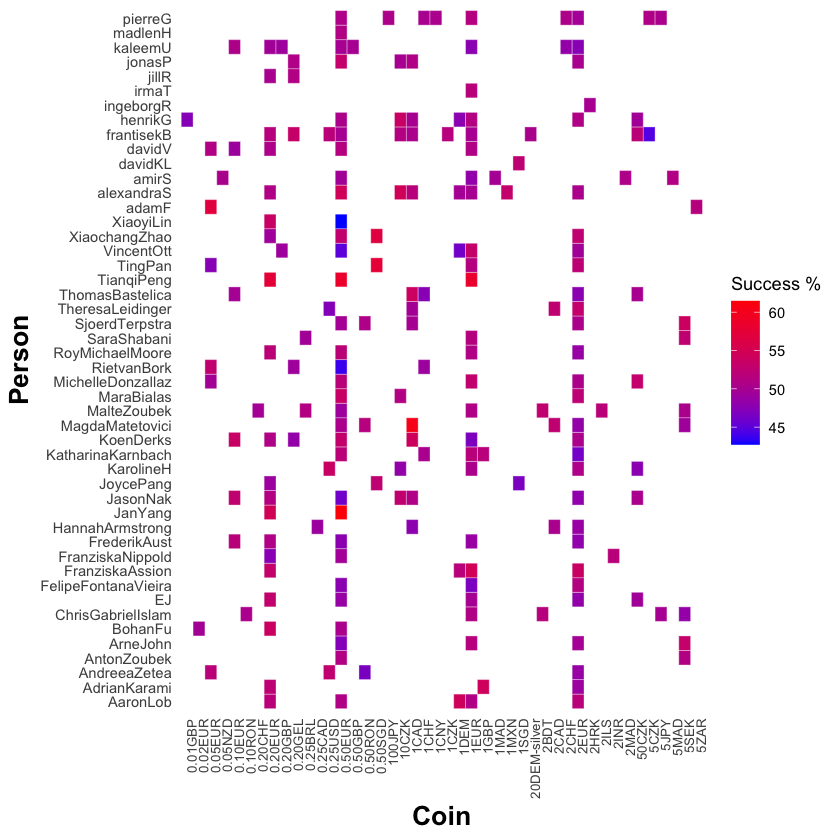

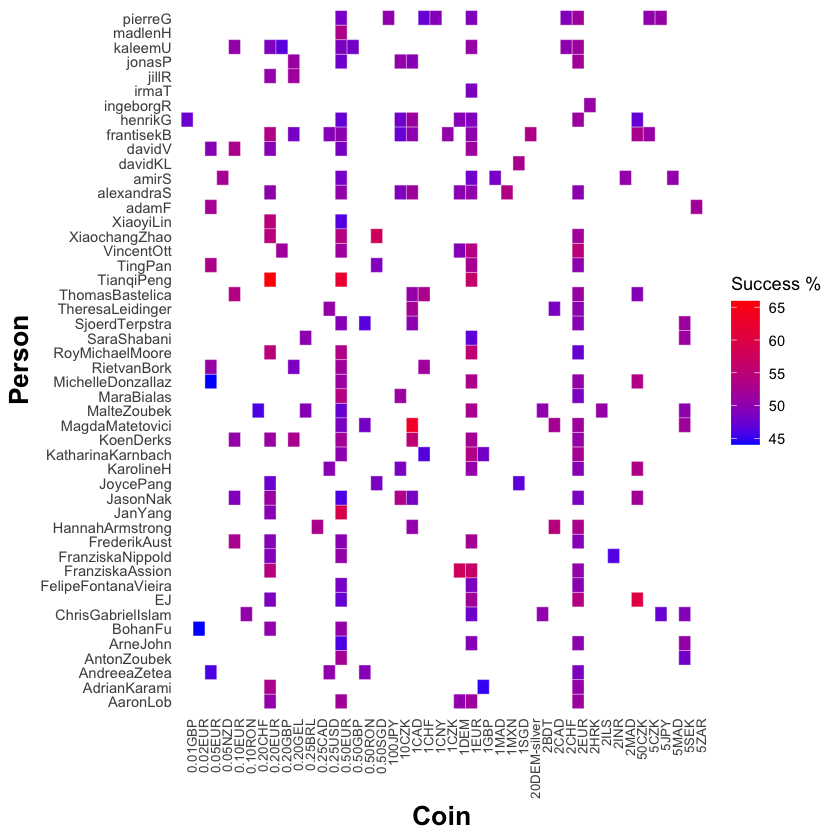

In [108]:
percentages <- df %>%
  group_by(person, coin) %>%
  summarise(
    success_total = 100 * sum(y) / sum(m),                                      # Pourcentage total
    success_heads = 100 * sum(y[start == "heads"]) / sum(m[start == "heads"]),  # Pourcentage pour heads
    success_tails = 100 * sum(y[start == "tails"]) / sum(m[start == "tails"])   # Pourcentage pour tails
  ) %>%
  pivot_longer(
    cols = starts_with("success"),
    names_to = "type",
    values_to = "percentage"
  )

# Heatmap pour total_success
ggplot(filter(percentages, type == "success_total"), aes(x = coin, y = person, fill = percentage)) +
  geom_tile(color = "white") +
  scale_fill_gradient(low = "blue", high = "red", name = "Success %") +
  labs(
    #title = "Total Success Percentage by Person and Coin",
    x = "Coin",
    y = "Person"
  ) +
   theme_minimal() +
  theme(
    axis.text.x = element_text(size = 8,  angle = 90, hjust = 1),  # Taille des étiquettes x
    axis.title.x = element_text(size = 16, face = "bold"),        # Taille et style du titre x
    axis.title.y = element_text(size = 16, face = "bold"),        # Taille et style du titre y
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5)
  ) + 
  theme(
    panel.grid = element_blank()
  )

# Heatmap pour success_heads
ggplot(filter(percentages, type == "success_heads"), aes(x = coin, y = person, fill = percentage)) +
  geom_tile(color = "white") +
  scale_fill_gradient(low = "blue", high = "red", name = "Success %") +
  labs(
    #title = "Success Percentage (Heads Start) by Person and Coin",
    x = "Coin",
    y = "Person"
  ) +
   theme_minimal() +
  theme(
    axis.text.x = element_text(size = 8,  angle = 90, hjust = 1),  # Taille des étiquettes x
    axis.title.x = element_text(size = 16, face = "bold"),        # Taille et style du titre x
    axis.title.y = element_text(size = 16, face = "bold"),        # Taille et style du titre y
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5)
  ) + 
  theme(
    panel.grid = element_blank()
  )

# Heatmap pour success_tails
ggplot(filter(percentages, type == "success_tails"), aes(x = coin, y = person, fill = percentage)) +
  geom_tile(color = "white") +
  scale_fill_gradient(low = "blue", high = "red", name = "Success %") +
  labs(
    #title = "Success Percentage (Tails Start) by Person and Coin",
    x = "Coin",
    y = "Person"
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(size = 8,  angle = 90, hjust = 1),  # Taille des étiquettes x
    axis.title.x = element_text(size = 16, face = "bold"),        # Taille et style du titre x
    axis.title.y = element_text(size = 16, face = "bold"),        # Taille et style du titre y
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5)
  ) + 
  theme(
    panel.grid = element_blank()
  )

# Data selection


As some participant ou some coin were tossed a larger number of time than other, they will have more impact on regression we want to do. So, to limit that regression, we want to take a maximum number of tosses per combination person/coin. The goal is that all data are under 4/(number of data) -> Cook's distance

For the logistic regression and WLS, we take a random number of line in the table 'df_time_agg' et we choose to not take into account the learning process (if there is one)

In [12]:
sampled_data <- df_time_agg %>%
  group_by(person, coin) %>%
  sample_n(size = min(3, n()), replace = FALSE) %>%
  ungroup() %>%
  mutate(tails_tails = N_start_tails_up - tails_heads) %>%
  select(heads_heads, tails_tails, N, person, coin)

print(sampled_data)


# A tibble: 628 x 5
   heads_heads tails_tails     N person   coin   
         <int>       <int> <int> <chr>    <chr>  
 1          29          27   100 AaronLob 0.20EUR
 2          24          30   100 AaronLob 0.20EUR
 3          22          26   100 AaronLob 0.20EUR
 4          31          27   100 AaronLob 0.50EUR
 5          19          37   100 AaronLob 0.50EUR
 6          30          24   100 AaronLob 0.50EUR
 7          31          26   100 AaronLob 1DEM   
 8          27          23   100 AaronLob 1DEM   
 9          23          25   100 AaronLob 1DEM   
10          31          24   100 AaronLob 1EUR   
# i 618 more rows


In [13]:
nb_toss_per_person_1 <- sampled_data %>%
    select(N, person) %>%
    group_by(person) %>%
    summarise(N = sum(N))


nb_toss_per_person_1

person,N
<chr>,<int>
AaronLob,1500
AdrianKarami,900
AndreeaZetea,1217
AntonZoubek,600
ArneJohn,1200
BohanFu,900
ChrisGabrielIslam,1500
EJ,1400
FelipeFontanaVieira,903


Participants throw between 500 and 5500 tosses

In [14]:
nb_toss_per_coin_1 <- sampled_data %>%
    select(N, coin) %>%
    group_by(coin) %>%
    summarise(N = sum(N))


table(nb_toss_per_coin_1$N)


 100  300  301  302  303  314  600  601  900  916  930 1200 1500 1506 1801 1815 
   1   12    2    2    1    1    7    1    1    1    1    2    1    1    1    1 
2000 2100 2103 3100 6008 7502 8422 9688 
   1    1    1    1    1    1    1    1 

Coin are used between 100 and 16098 times

In [15]:
sampled_data_model <- sampled_data %>%
    mutate(y = heads_heads + tails_tails) %>%
    rename(m=N) %>%
    select(y,m,person,coin) %>%
    group_by(person, coin) %>%
    summarize(m=sum(m), y=sum(y))

print(sampled_data_model)

table(sampled_data_model$m)

`summarise()` has grouped output by 'person'. You can override using the
`.groups` argument.


# A tibble: 211 x 4
# Groups:   person [48]
   person       coin        m     y
   <chr>        <chr>   <int> <int>
 1 AaronLob     0.20EUR   300   158
 2 AaronLob     0.50EUR   300   168
 3 AaronLob     1DEM      300   155
 4 AaronLob     1EUR      300   159
 5 AaronLob     2EUR      300   158
 6 AdrianKarami 0.20EUR   300   163
 7 AdrianKarami 1GBP      300   146
 8 AdrianKarami 2EUR      300   148
 9 AndreeaZetea 0.05EUR   300   154
10 AndreeaZetea 0.25USD   300   147
# i 201 more rows



100 200 300 301 302 303 304 305 314 315 316 317 330 332 333 
  2   1 177  11   6   4   1   1   2   1   1   1   1   1   1 

# Model with new data

## Model selection with new data

In [16]:
glmIntercept1 = glm(cbind(y,m-y)~1,family=binomial,data=sampled_data_model)
#summary(glmIntercept) 

glmTotal1 = glm(cbind(y,m-y)~1+person+coin,family=binomial,data=sampled_data_model)
summary(glmTotal1)

glmPerson1 = glm(cbind(y,m-y)~1+person,family=binomial,data=sampled_data_model)
summary(glmPerson1)

glmCoin1 = glm(cbind(y,m-y)~1+coin,family=binomial,data=sampled_data_model)
#summary(glmCoin)


Call:
glm(formula = cbind(y, m - y) ~ 1 + person + coin, family = binomial, 
    data = sampled_data_model)

Coefficients: (1 not defined because of singularities)
                           Estimate Std. Error z value Pr(>|z|)  
(Intercept)                0.064706   0.134623   0.481   0.6308  
personAdrianKarami        -0.121392   0.091490  -1.327   0.1846  
personAndreeaZetea        -0.175659   0.084815  -2.071   0.0384 *
personAntonZoubek         -0.244673   0.101920  -2.401   0.0164 *
personArneJohn            -0.054627   0.079945  -0.683   0.4944  
personBohanFu             -0.101879   0.098300  -1.036   0.3000  
personChrisGabrielIslam   -0.148031   0.089605  -1.652   0.0985 .
personEJ                  -0.058660   0.075618  -0.776   0.4379  
personFelipeFontanaVieira -0.057125   0.085467  -0.668   0.5039  
personFranziskaAssion     -0.024847   0.077820  -0.319   0.7495  
personFranziskaNippold    -0.092149   0.098025  -0.940   0.3472  
personFrederikAust        -0.142386   0.074


Call:
glm(formula = cbind(y, m - y) ~ 1 + person, family = binomial, 
    data = sampled_data_model)

Coefficients:
                          Estimate Std. Error z value Pr(>|z|)   
(Intercept)                0.12818    0.05175   2.477  0.01325 * 
personAdrianKarami        -0.09706    0.08440  -1.150  0.25013   
personAndreeaZetea        -0.17255    0.07724  -2.234  0.02548 * 
personAntonZoubek         -0.22826    0.09675  -2.359  0.01831 * 
personArneJohn            -0.04145    0.07757  -0.534  0.59306   
personBohanFu             -0.14595    0.08439  -1.729  0.08373 . 
personChrisGabrielIslam   -0.15751    0.07311  -2.154  0.03120 * 
personEJ                  -0.05958    0.07442  -0.801  0.42338   
personFelipeFontanaVieira -0.06392    0.08433  -0.758  0.44846   
personFranziskaAssion     -0.01472    0.07760  -0.190  0.84955   
personFranziskaNippold    -0.12600    0.08385  -1.503  0.13291   
personFrederikAust        -0.13351    0.07310  -1.826  0.06781 . 
personHannahArmstrong    

### Anova

In [17]:
anova(glmIntercept1, glmPerson1, glmCoin1, glmTotal1, test = "LRT") # person + coin 

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,210,259.6922,NA,NA,NA
2,163,194.2001,47,65.49210,0.03842414
3,167,192.2285,-4,1.97157,NA
4,121,136.5862,46,55.64233,0.15601098


### Forward/Backward selection

In [18]:
step(glmTotal1, direction = "backward", trace = 0) #person
step(glmTotal1, direction = "both", trace = 0) #person
step(glmTotal1, direction = "forward", trace = 0) # person + coin


Call:  glm(formula = cbind(y, m - y) ~ 1, family = binomial, data = sampled_data_model)

Coefficients:
(Intercept)  
     0.0406  

Degrees of Freedom: 210 Total (i.e. Null);  210 Residual
Null Deviance:	    259.7 
Residual Deviance: 259.7 	AIC: 1558


Call:  glm(formula = cbind(y, m - y) ~ 1, family = binomial, data = sampled_data_model)

Coefficients:
(Intercept)  
     0.0406  

Degrees of Freedom: 210 Total (i.e. Null);  210 Residual
Null Deviance:	    259.7 
Residual Deviance: 259.7 	AIC: 1558


Call:  glm(formula = cbind(y, m - y) ~ 1 + person + coin, family = binomial, 
    data = sampled_data_model)

Coefficients:
              (Intercept)         personAdrianKarami  
                 0.064706                  -0.121392  
       personAndreeaZetea          personAntonZoubek  
                -0.175659                  -0.244673  
           personArneJohn              personBohanFu  
                -0.054627                  -0.101879  
  personChrisGabrielIslam                   personEJ  
                -0.148031                  -0.058660  
personFelipeFontanaVieira      personFranziskaAssion  
                -0.057125                  -0.024847  
   personFranziskaNippold         personFrederikAust  
                -0.092149                  -0.142386  
    personHannahArmstrong              personJanYang  
                -0.138433                   0.079847  
           personJasonNak            personJoycePang  
                -0.133815                  -0.2095

## Model fit

In [19]:
glm_model1 <- glm(cbind(y,m-y)~ 1+person +coin ,family=binomial,data=sampled_data_model)

## Model checking

In [20]:
residuals_deviance1 <- residuals(glm_model1, type = "deviance")
residuals_pearson1 <- residuals(glm_model1, type = "pearson")

### Linearity

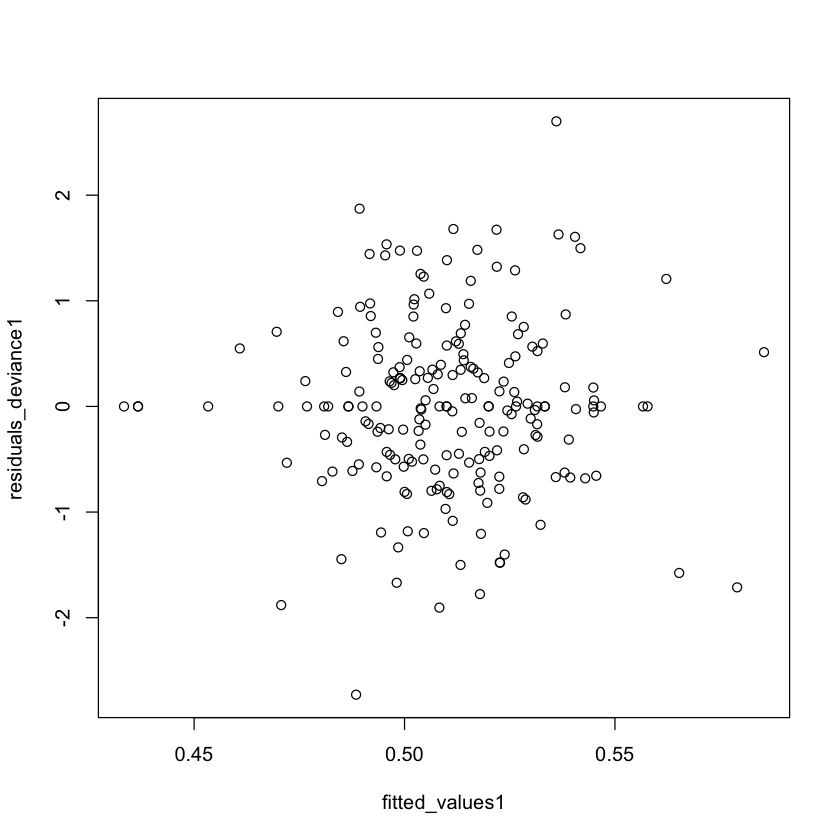

In [21]:
fitted_values1 <- predict(glm_model1, data= df, type = "response")

plot( fitted_values1, residuals_deviance1)

### Response distribution 

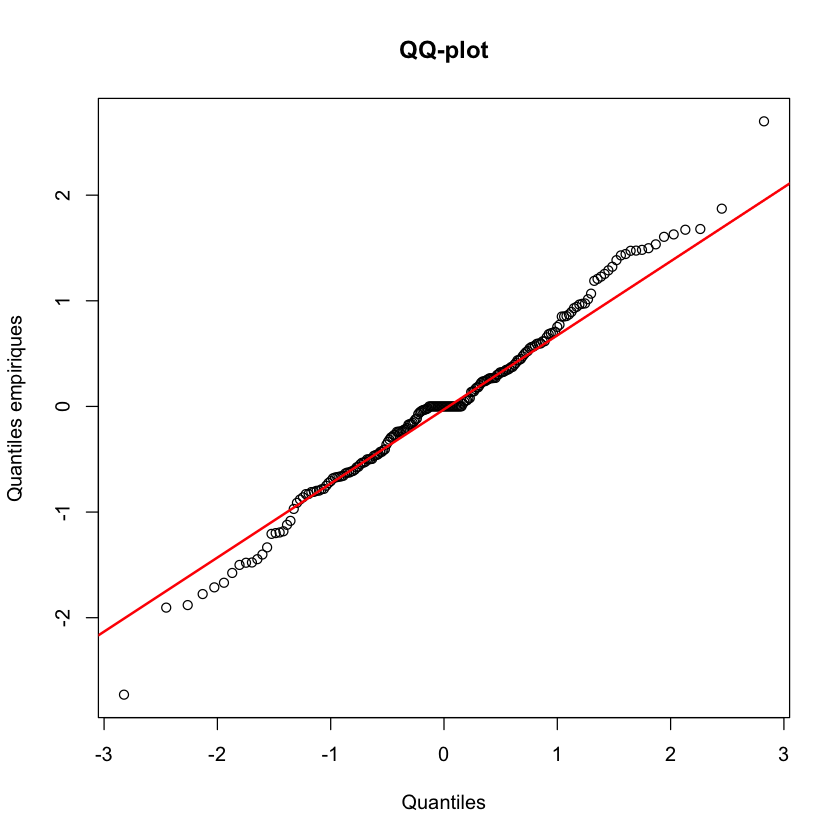

In [22]:
qqnorm(residuals_deviance1, main = "QQ-plot", xlab = "Quantiles", ylab = "Quantiles empiriques")

qqline(residuals_deviance1, col = "red", lwd = 2)

# Standardized deviance residuals 
residuals_d_std1 <- residuals_deviance1 / sqrt(1 - hatvalues(glm_model1))

#qqnorm(residuals_d_std1, main = "QQ-plot", xlab = "Quantiles", ylab = "Quantiles empiriques")

#qqline(residuals_d_std1, col = "red", lwd = 2)
# Not a big difference between them 


### Independence

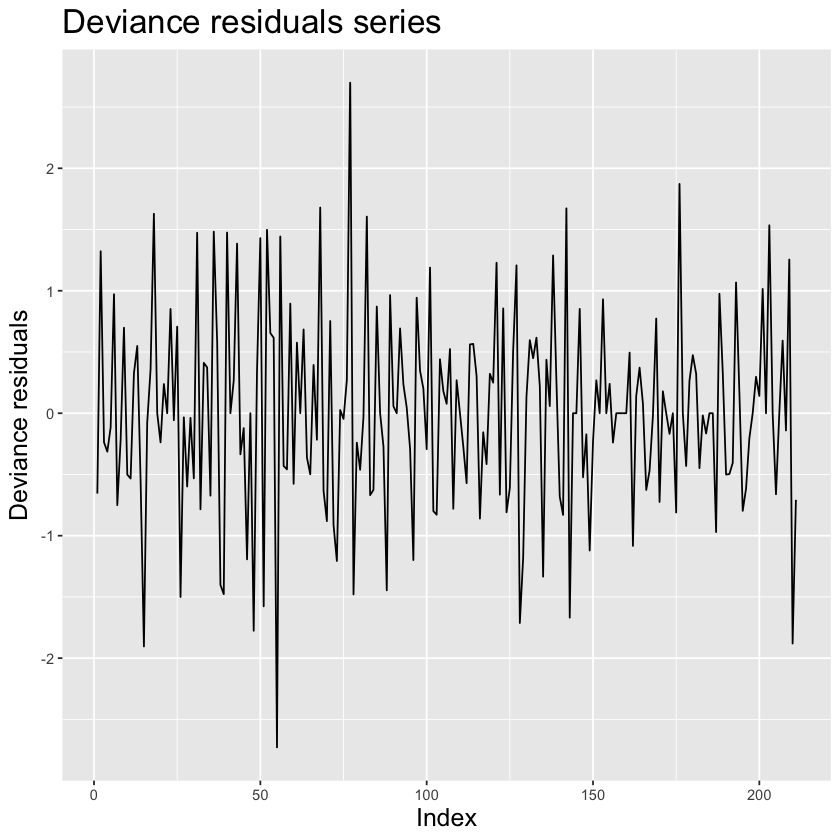

In [23]:
residuals_df1 <- data.frame(Residuals = residuals_deviance1, Index = seq_along(residuals_deviance1))
ggplot(residuals_df1, aes(x = Index, y = Residuals)) +
  geom_line() +
  labs(x = "Index", y = "Deviance residuals") +
  ggtitle("Deviance residuals series") +
  theme(axis.title = element_text(size = 15),  
        plot.title = element_text(size = 20))

### Cook's distance

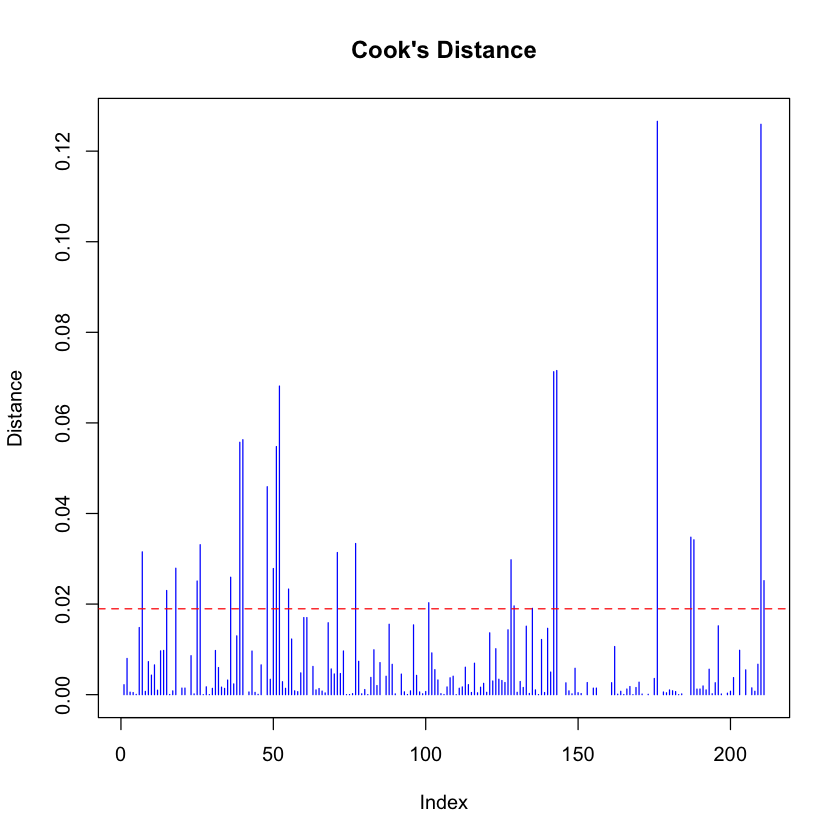

In [24]:
cooks_distance1 <- cooks.distance(glm_model1)

plot(cooks_distance1, main = "Cook's Distance", ylab = "Distance", type = "h", col = "blue")
abline(h = 4/(length(cooks_distance1)), col = "red", lty = 2) # rule of thumb 

In [25]:
threshold <- 4 / nrow(sampled_data_model)

influential_points <- which(cooks_distance1 > threshold)
influential_data <- sampled_data_model[influential_points, ]
print(influential_data)

# A tibble: 26 x 4
# Groups:   person [18]
   person            coin        m     y
   <chr>             <chr>   <int> <int>
 1 AdrianKarami      1GBP      300   146
 2 ArneJohn          0.50EUR   300   136
 3 ArneJohn          5SEK      300   175
 4 ChrisGabrielIslam 5JPY      300   147
 5 ChrisGabrielIslam 5SEK      300   141
 6 FranziskaAssion   1DEM      300   168
 7 FranziskaNippold  0.20EUR   302   145
 8 FranziskaNippold  0.50EUR   303   164
 9 HannahArmstrong   1CAD      300   140
10 HannahArmstrong   2EUR      300   161
# i 16 more rows


## Performance

In [26]:
pred_probs1<- predict(glm_model1, type = "response")
print(mean(pred_probs1))

[1] 0.510217


### ROC curve

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.8069

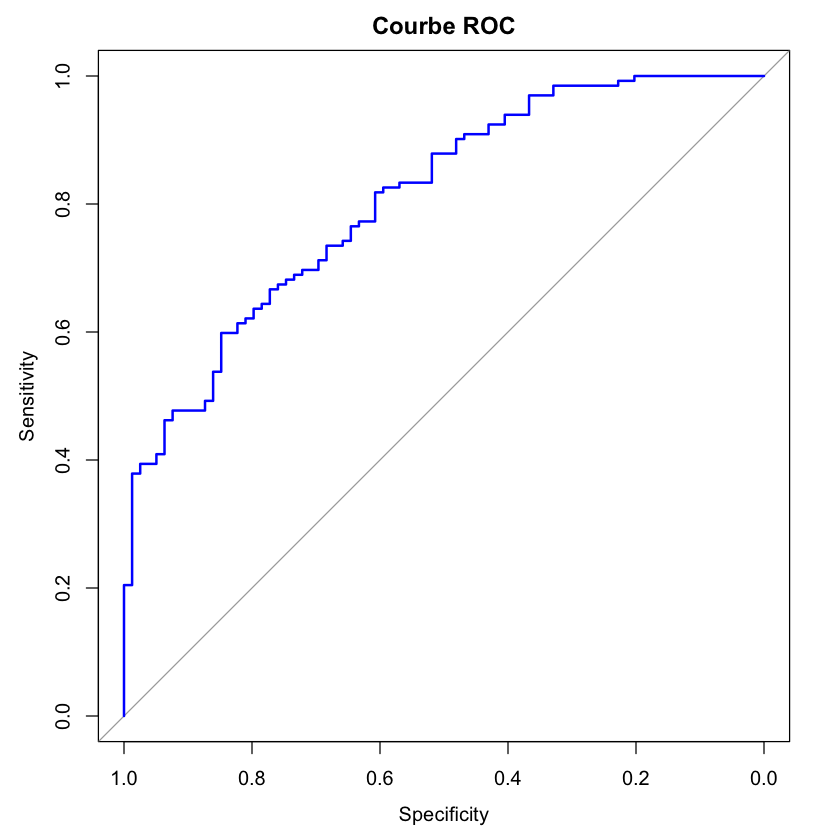

In [27]:
actual_classes1 <- ifelse(sampled_data_model$y > (sampled_data_model$m / 2), 1, 0)

roc_curve1 <- roc(actual_classes1, pred_probs1)

plot(roc_curve1, main = "Courbe ROC", col = "blue", lwd = 2)

auc(roc_curve1)

### Confusion matrix/ Accuracy

In [28]:

# Calculer les succès attendus (probabilité * nombre d'essais)
# Ici, m est le nombre total d'essais pour chaque observation
pred_successes1 <- pred_probs1 * sampled_data_model$m

# Convertir en classes binaires : succès ou échec
# Si le nombre de succès observé est supérieur à la moitié du nombre total d'essais, on peut dire que c'est un succès global
pred_classes1 <- ifelse(pred_successes1 > (sampled_data_model$m / 2), 1, 0)

# Convertir les valeurs réelles en classes binaires
# Si y (le nombre de succès observé) est supérieur à la moitié du nombre total d'essais, c'est un succès global
actual_classes1 <- ifelse(sampled_data_model$y > (sampled_data_model$m / 2), 1, 0)

# Créer la confusion matrix en comparant les classes binaires observées et prédites
confusion_matrix1 <- table(Predicted = pred_classes1, Actual = actual_classes1)

accuracy1 <- sum(diag(confusion_matrix1)) / sum(confusion_matrix1)
print(paste("Accuracy: ", accuracy1))

[1] "Accuracy:  0.725118483412322"


# Model with all data

## Model selection with all data

In [29]:
glmIntercept = glm(cbind(y,m-y)~1,family=binomial,data=df)
#summary(glmIntercept) 

glmTotal = glm(cbind(y,m-y)~1+person+coin,family=binomial,data=df)
#summary(glmTotal)

glmPerson = glm(cbind(y,m-y)~1+person,family=binomial,data=df)
summary(glmPerson)

glmCoin = glm(cbind(y,m-y)~1+coin,family=binomial,data=df)
#summary(glmCoin)


Call:
glm(formula = cbind(y, m - y) ~ 1 + person, family = binomial, 
    data = df)

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)                0.062182   0.023261   2.673 0.007512 ** 
personAdrianKarami        -0.004519   0.041455  -0.109 0.913192    
personAndreeaZetea        -0.093009   0.037878  -2.455 0.014069 *  
personAntonZoubek         -0.035391   0.030675  -1.154 0.248607    
personArneJohn            -0.075516   0.039582  -1.908 0.056414 .  
personBohanFu             -0.029452   0.048577  -0.606 0.544319    
personChrisGabrielIslam   -0.074776   0.030674  -2.438 0.014778 *  
personEJ                  -0.041694   0.038946  -1.071 0.284369    
personFelipeFontanaVieira -0.082353   0.030668  -2.685 0.007246 ** 
personFranziskaAssion      0.101339   0.040009   2.533 0.011313 *  
personFranziskaNippold    -0.066087   0.030214  -2.187 0.028724 *  
personFrederikAust        -0.073992   0.030365  -2.437 0.014820 *  
personHannahArm

Some participants are statistically significant: the probability of landing on the same side of the coin as the initial side depends on the person flipping it, but only for certain individuals. Therefore, we can divide the participants into two groups: those who influence this probability, like JanYang, and those who do not, like Adrian Karami.

In [30]:
anova(glmIntercept, glmPerson, glmCoin, glmTotal, test = "LRT") # person + coin 

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,421,686.8612,NA,NA,NA
2,374,420.6084,47,266.2528,2.139090e-32
3,378,585.5556,-4,-164.9472,1.269778e-34
4,332,354.2164,46,231.3392,1.570205e-26


We can see on the previous table that adding both person and coin is statistically significant

In [31]:
step(glmTotal, direction = "backward", trace = 0) #person
step(glmTotal, direction = "both", trace = 0) #person
step(glmTotal, direction = "forward", trace = 0) # person + coin


Call:  glm(formula = cbind(y, m - y) ~ person, family = binomial, data = df)

Coefficients:
              (Intercept)         personAdrianKarami  
                 0.062182                  -0.004519  
       personAndreeaZetea          personAntonZoubek  
                -0.093009                  -0.035391  
           personArneJohn              personBohanFu  
                -0.075516                  -0.029452  
  personChrisGabrielIslam                   personEJ  
                -0.074776                  -0.041694  
personFelipeFontanaVieira      personFranziskaAssion  
                -0.082353                   0.101339  
   personFranziskaNippold         personFrederikAust  
                -0.066087                  -0.073992  
    personHannahArmstrong              personJanYang  
                -0.028846                   0.200705  
           personJasonNak            personJoycePang  
                -0.060988                  -0.103927  
          personKarolineH  


Call:  glm(formula = cbind(y, m - y) ~ person, family = binomial, data = df)

Coefficients:
              (Intercept)         personAdrianKarami  
                 0.062182                  -0.004519  
       personAndreeaZetea          personAntonZoubek  
                -0.093009                  -0.035391  
           personArneJohn              personBohanFu  
                -0.075516                  -0.029452  
  personChrisGabrielIslam                   personEJ  
                -0.074776                  -0.041694  
personFelipeFontanaVieira      personFranziskaAssion  
                -0.082353                   0.101339  
   personFranziskaNippold         personFrederikAust  
                -0.066087                  -0.073992  
    personHannahArmstrong              personJanYang  
                -0.028846                   0.200705  
           personJasonNak            personJoycePang  
                -0.060988                  -0.103927  
          personKarolineH  


Call:  glm(formula = cbind(y, m - y) ~ 1 + person + coin, family = binomial, 
    data = df)

Coefficients:
              (Intercept)         personAdrianKarami  
                -0.054801                  -0.007757  
       personAndreeaZetea          personAntonZoubek  
                -0.091120                  -0.037123  
           personArneJohn              personBohanFu  
                -0.078879                  -0.009212  
  personChrisGabrielIslam                   personEJ  
                -0.106006                  -0.047603  
personFelipeFontanaVieira      personFranziskaAssion  
                -0.081891                   0.103457  
   personFranziskaNippold         personFrederikAust  
                -0.055983                  -0.083067  
    personHannahArmstrong              personJanYang  
                -0.060384                   0.198208  
           personJasonNak            personJoycePang  
                -0.079157                  -0.159874  
          p

Variable selection: 
- forward selection: select only person
- both direction selection: select only person
- forward selection: select both person and coin

In [32]:
glm_model <- glm(cbind(y,m-y)~1+person,family=binomial,data=df)

In [33]:
alias(glm_model)

Model :
cbind(y, m - y) ~ 1 + person


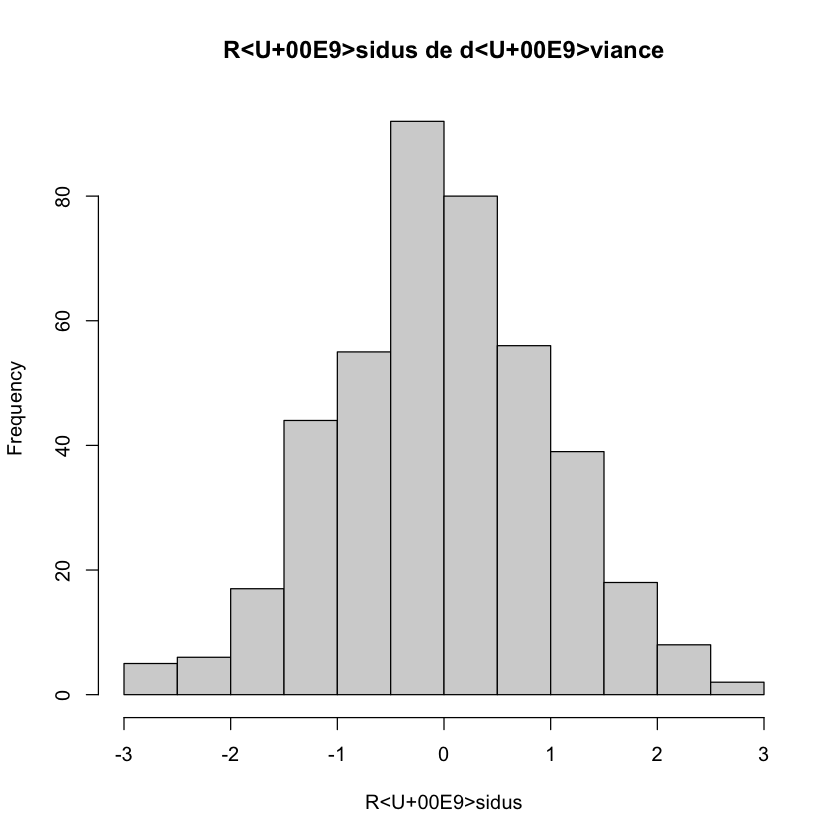

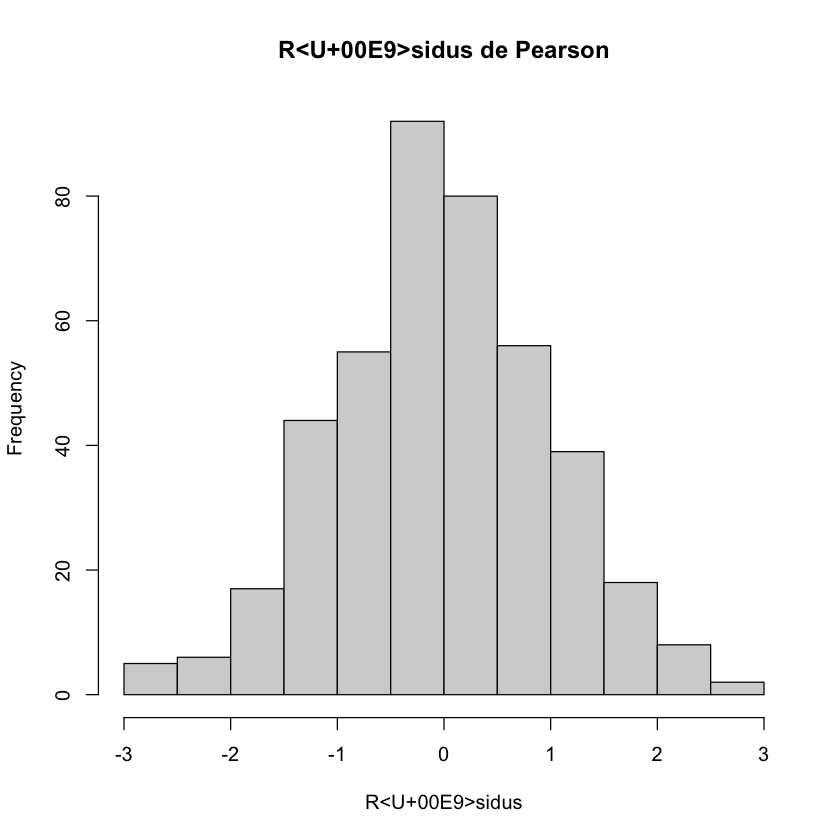

In [34]:
residuals_deviance <- residuals(glm_model, type = "deviance")
residuals_pearson <- residuals(glm_model, type = "pearson")

# Histogrammes des résidus
hist(residuals_deviance, breaks = 20, main = "Résidus de déviance", xlab = "Résidus")
hist(residuals_pearson, breaks = 20, main = "Résidus de Pearson", xlab = "Résidus")

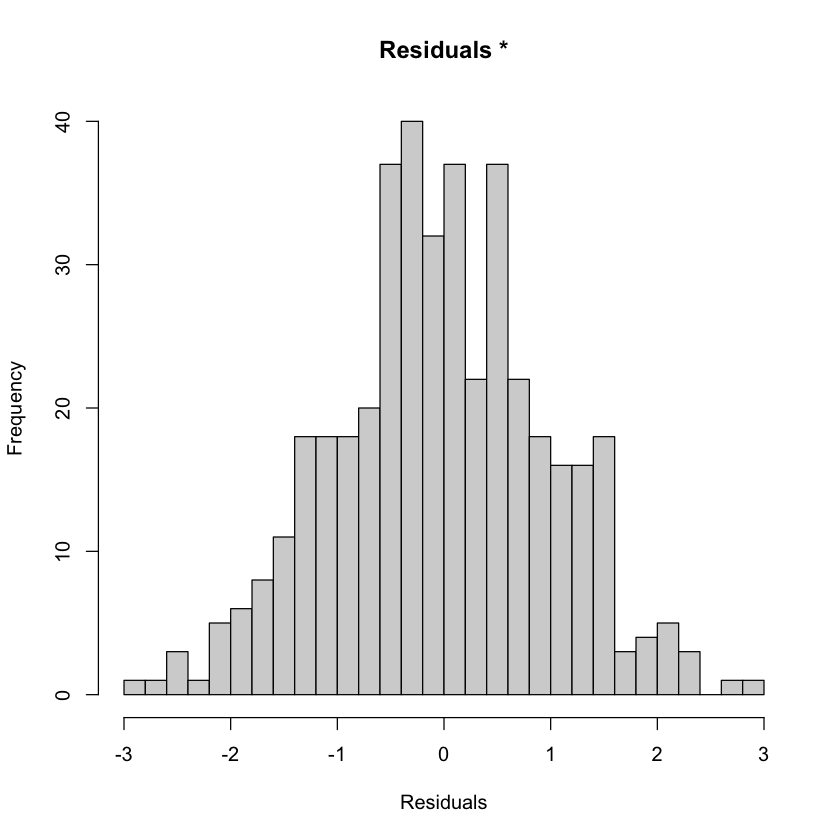

In [35]:
# Standardized deviance residual
std_deviance_residuals <- residuals_deviance / sqrt(1 - hatvalues(glm_model))

#Standardized pearson residual
std_pearson_residuals <- residuals_pearson / sqrt(1 - hatvalues(glm_model))

residuals <- residuals_deviance + log(residuals_pearson/residuals_deviance)/residuals_deviance # nolint

hist(residuals, breaks = 30, main = "Residuals *", xlab = "Residuals")


## Model checking

### 1. Linearity 

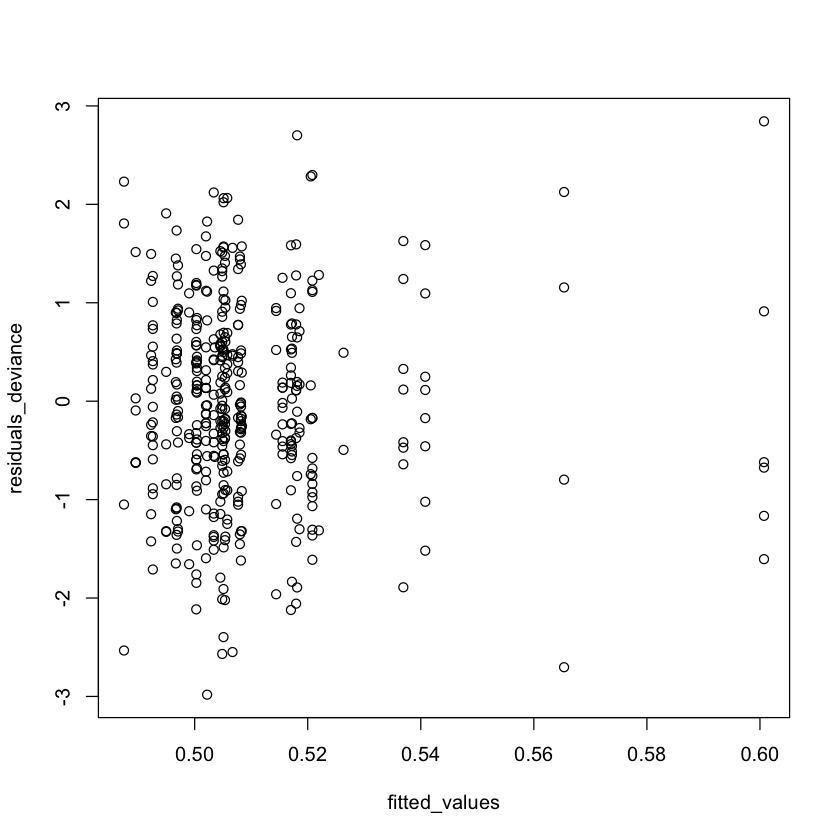

In [36]:
fitted_values <- predict(glm_model, data= df, type = "response")

plot( fitted_values, residuals_deviance)

• The deviance residuals versus fitted values plot indicates that the residuals are generally centered around zero, which is a positive sign for model fit.

•A high concentration of points is observed around fitted values between 0.50 and 0.52, suggesting the model struggles to differentiate observations in this range.

•Greater dispersion of residuals for fitted values above 0.54 may point to potential heteroscedasticity (non-constant variance).

•A few outliers or influential points are visible, particularly at the extremes of the residuals, warranting further investigation.

### 2. Response distribution

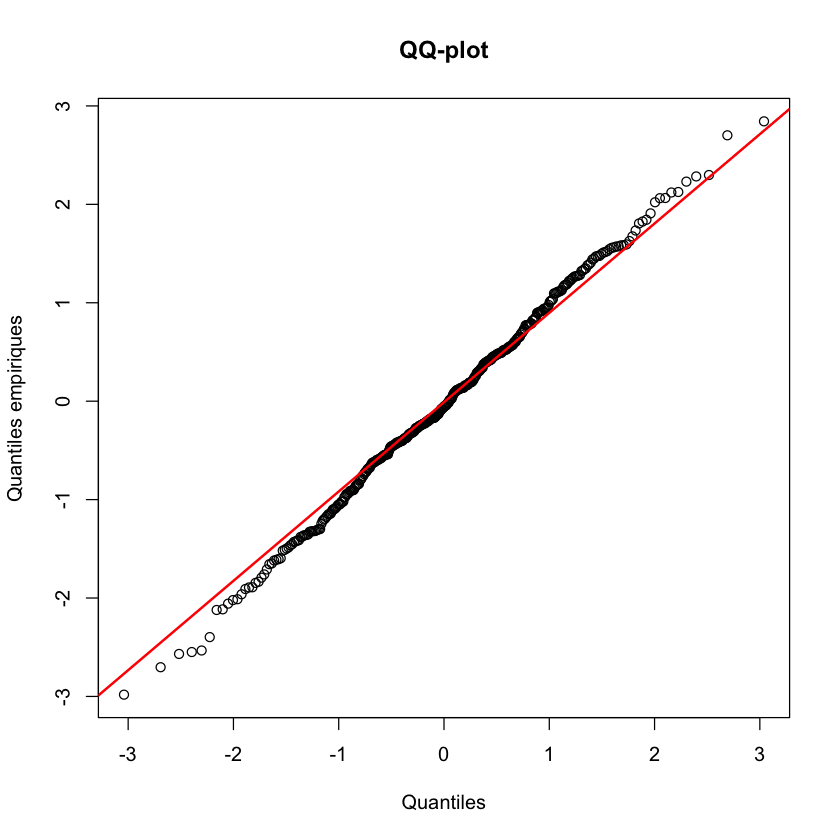

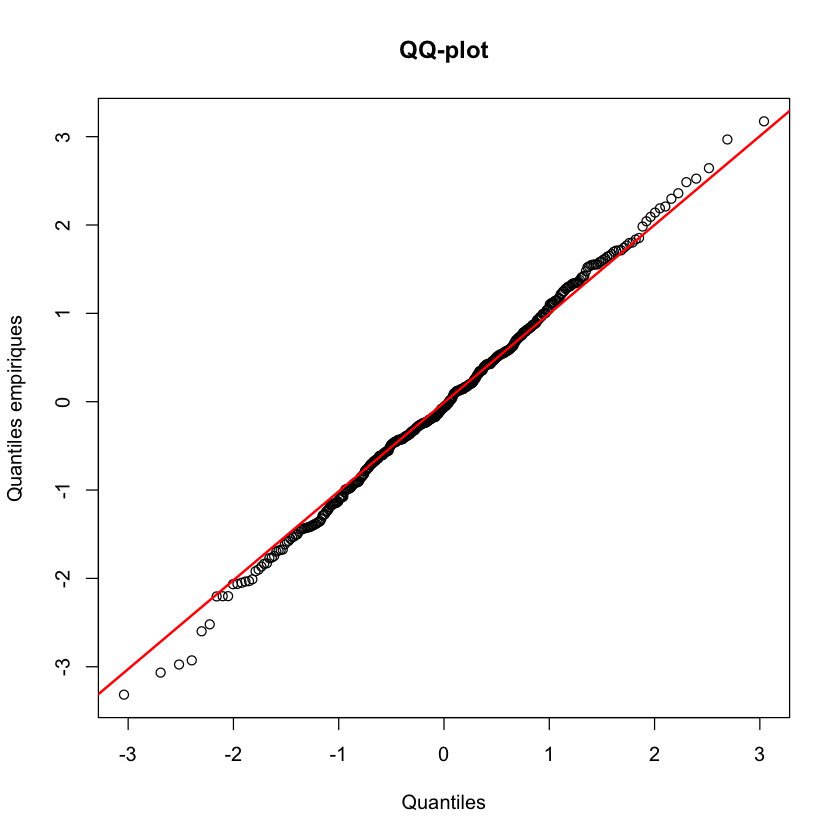

In [37]:
qqnorm(residuals_deviance, main = "QQ-plot", xlab = "Quantiles", ylab = "Quantiles empiriques")

qqline(residuals_deviance, col = "red", lwd = 2)

# Standardized deviance residuals 
residuals_d_std <- residuals_deviance / sqrt(1 - hatvalues(glm_model))

qqnorm(residuals_d_std, main = "QQ-plot", xlab = "Quantiles", ylab = "Quantiles empiriques")

qqline(residuals_d_std, col = "red", lwd = 2)
# Not a big difference between them 


• Good alignment: Most points follow the diagonal line, indicating the residuals generally follow a normal distribution.

• Tail deviations: Some deviations at the extremes suggest potential outliers or slight non-normality.

• Conclusion: The model fits well overall, with minor issues in the tails.

### 3. Independence (autocorrelation of the residuals)

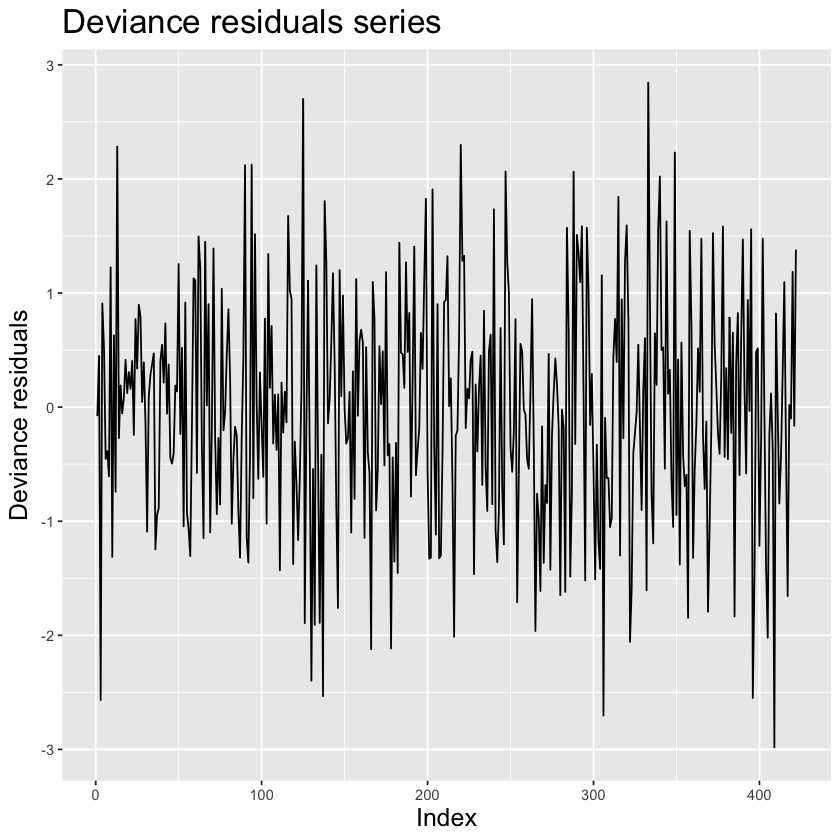

In [38]:
residuals_df <- data.frame(Residuals = residuals_deviance, Index = seq_along(residuals_deviance))
ggplot(residuals_df, aes(x = Index, y = Residuals)) +
  geom_line() +
  labs(x = "Index", y = "Deviance residuals") +
  ggtitle("Deviance residuals series") +
  theme(axis.title = element_text(size = 15),  
        plot.title = element_text(size = 20))

• Centered Around Zero: Residuals oscillate around zero, suggesting no major bias.

• Spread: Most values lie between -2 and 2, with a stable variance.

• Outliers: A few points near -3 or 3 may indicate potential outliers.

• Patterns: No clear trends or periodicity visible, suggesting independence.

### 4. Cook's distance

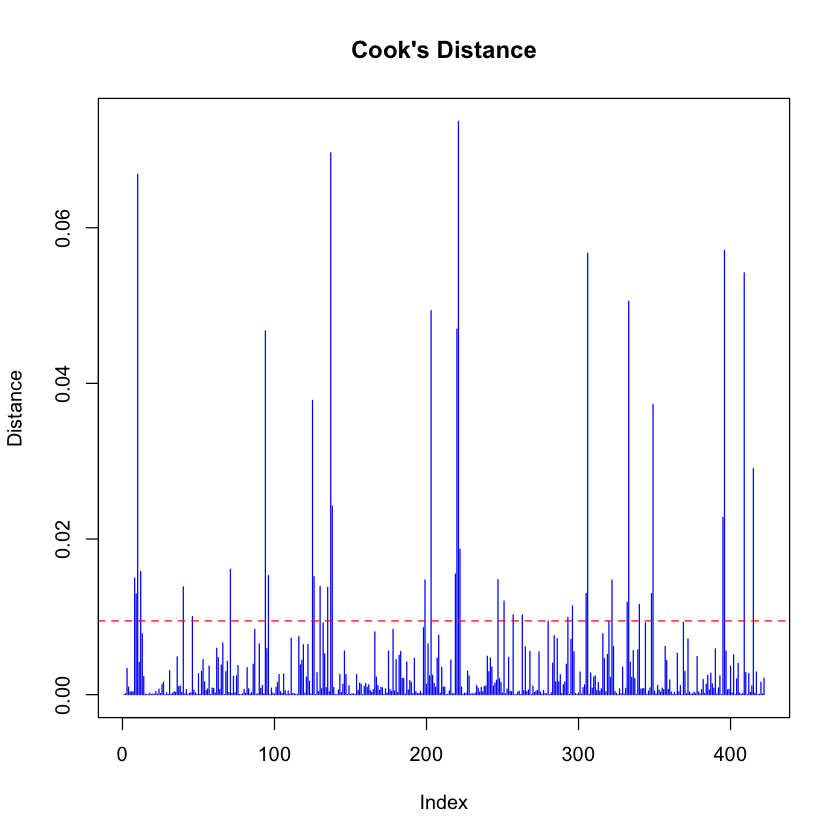

In [39]:
cooks_distance <- cooks.distance(glm_model)

plot(cooks_distance, main = "Cook's Distance", ylab = "Distance", type = "h", col = "blue")
abline(h = 4/(length(cooks_distance)), col = "red", lty = 2) # rule of thumb 

Since some people toss many more coins than others, some observations influence the model much more.

## Performance

### ROC curve and AUC 

In [40]:
pred_probs<- predict(glm_model, type = "response")
print(mean(pred_probs))

[1] 0.5084848


Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.687

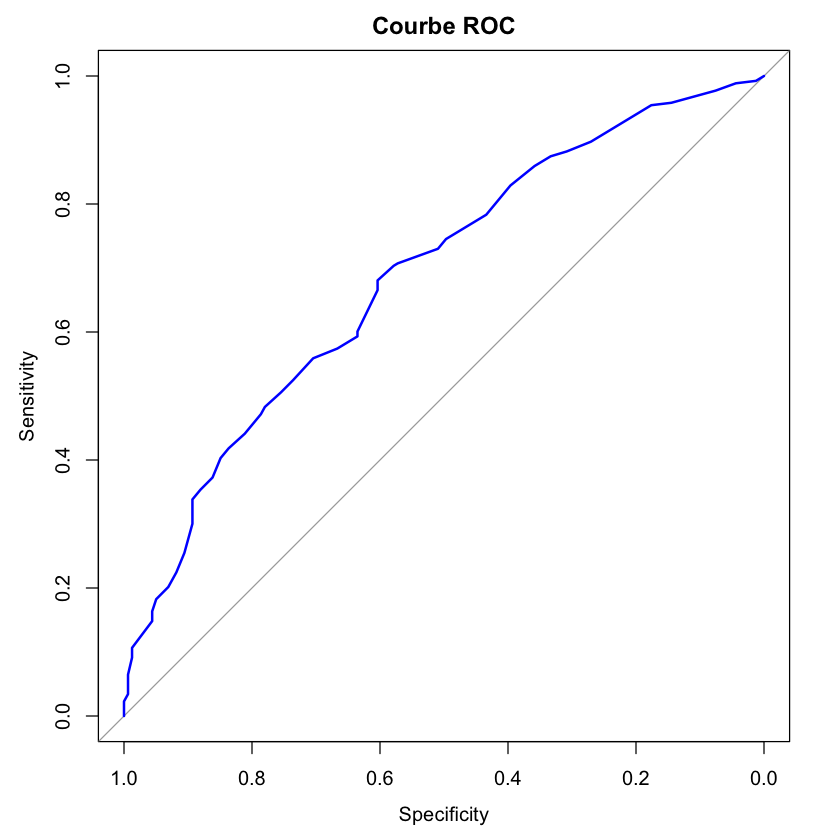

In [41]:
actual_classes <- ifelse(df$y > (df$m / 2), 1, 0)

roc_curve <- roc(actual_classes, pred_probs)

plot(roc_curve, main = "Courbe ROC", col = "blue", lwd = 2)

auc(roc_curve)

### Confusion matrix and accuracy

In [42]:

# Prédire les probabilités de succès avec le modèle (pour chaque observation)
pred_probs <- predict(glm_model, type = "response")

# Calculer les succès attendus (probabilité * nombre d'essais)
# Ici, m est le nombre total d'essais pour chaque observation
pred_successes <- pred_probs * df$m

# Convertir en classes binaires : succès ou échec
# Si le nombre de succès observé est supérieur à la moitié du nombre total d'essais, on peut dire que c'est un succès global
pred_classes <- ifelse(pred_successes > (df$m / 2), 1, 0)

# Convertir les valeurs réelles en classes binaires
# Si y (le nombre de succès observé) est supérieur à la moitié du nombre total d'essais, c'est un succès global
actual_classes <- ifelse(df$y > (df$m / 2), 1, 0)

# Créer la confusion matrix en comparant les classes binaires observées et prédites
confusion_matrix <- table(Predicted = pred_classes, Actual = actual_classes)

accuracy <- sum(diag(confusion_matrix)) / sum(confusion_matrix)
print(paste("Accuracy: ", accuracy))

[1] "Accuracy:  0.670616113744076"


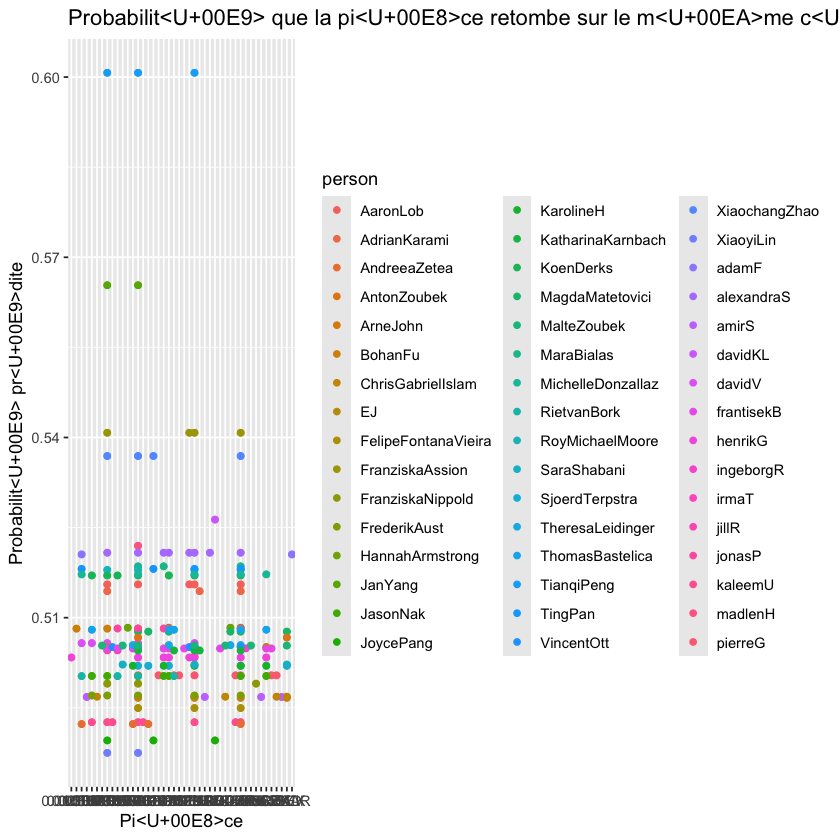

In [43]:
df$predicted_probs <- pred_probs

ggplot(df, aes(x = coin, y = predicted_probs, color = person)) +
  geom_point() +
  labs(title = "Probabilité que la pièce retombe sur le même côté",
       y = "Probabilité prédite", x = "Pièce")